In [10]:
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from tqdm import tqdm

out_dir = "../../output/plot_scenes"
os.makedirs(out_dir, exist_ok=True)

SEQ_IDX = {
    'Speed': 0,
    'Heading': 1,
    'Lat': 2,
    'Lon': 3,
    'Range': 4,
    'Bearing': 5,
    'x': 6,
    'y': 7,
    'z': 8,
    'Interp': 9
}

XY = [False, False, False, False, False, False, True, True, False, False]
LL = [False, False, True, True, False, False, False, False, False, False]

MAP_IDX = {
    'LatStart': 0,
    'LonStart': 1,
    'xStart': 2,
    'yStart': 3,
    'LatEnd': 4,
    'LonEnd': 5,
    'xEnd': 6,
    'yEnd': 7,
    'SemanticID': 8,
    'OSMID': 9,
}


COLOR_MAP = {
    'gt_hist': '#FF5A4C',
    'gt_future': '#8B5FBF',
    'holdline': "#0DD7EF",
    'follower': "#EF0D5C",
    'leader': "#93EF0D",
    'invalid': "#000000"
}

AIRCRAFT = 0
VEHICLE = 1
UNKNOWN = 2

ZOOM = {
    AIRCRAFT: 0.015,
    VEHICLE: 0.2,
    UNKNOWN: 0.2
}

In [11]:
import cv2
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import pickle

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy import ndimage

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def load_assets(base_dir:str, airport:str):
    assets_dir = os.path.join(base_dir, 'assets')
    map_dir = os.path.join(assets_dir, airport)
    graph_dir = os.path.join(base_dir, 'graph_data_a10v01os')
    airport_graph_dir = os.path.join(graph_dir, airport)

    raster_map_filepath = os.path.join(map_dir, "bkg_map.png")
    raster_map = cv2.imread(raster_map_filepath)
    raster_map = cv2.resize(raster_map, (raster_map.shape[0]//2, raster_map.shape[1]//2))
    raster_map = cv2.cvtColor(raster_map, cv2.COLOR_BGR2RGB)

    pickle_map_filepath = os.path.join(airport_graph_dir, "semantic_graph.pkl")
    with open(pickle_map_filepath, 'rb') as f:
        graph_pickle = pickle.load(f)
        hold_lines = graph_pickle['hold_lines']
        graph_nx = graph_pickle['graph_networkx']
        # pickle_map = temp_dict['map_infos']['all_polylines'][:]

    limits_filepath = os.path.join(map_dir, 'limits.json')
    with open(limits_filepath, 'r') as fp:
        ref_data = dotdict(json.load(fp))
    limits = (ref_data.north, ref_data.east, ref_data.south, ref_data.west)

    aircraft_filepath = os.path.join(assets_dir, "ac.png")
    aircraft = imageio.imread(aircraft_filepath)

    vehicle_filepath = os.path.join(assets_dir, "vc.png")
    vehicle = imageio.imread(vehicle_filepath)

    uk_filepath = os.path.join(assets_dir, "uk.png")
    unknown =  imageio.imread(uk_filepath)

    agents = {AIRCRAFT: aircraft, VEHICLE: vehicle, UNKNOWN: unknown}
    return raster_map, hold_lines, graph_nx, limits, agents

def plot_agent(asset, heading, zoom = 0.015):
    img = ndimage.rotate(asset, heading)
    img = np.fliplr(img)
    img = OffsetImage(img, zoom=zoom)
    return img

def save(filetag, dpi=400):
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])

    # Set figure bbox around the predicted trajectory
    # plt.show(block = False)
    plt.savefig(f'{filetag}.png', dpi=dpi, bbox_inches='tight')
    plt.close()

def plot_scene(scenario, assets, filetag, order_list = None):
    raster_map, hold_lines, graph_map, ll_extent, agents = assets
    north, east, south, west = ll_extent

    # Save states
    fig, movement_plot = plt.subplots()
    # Display global map
    movement_plot.imshow(
        raster_map.astype(float), zorder=0, extent=[west, east, south, north], alpha=0.8, cmap='gray_r')

    sequences = scenario['sequences']
    agent_types = scenario['agent_types']

    N, T, D = sequences.shape
    for n in range(N):
        # Get heading at last point of trajectory
        heading = sequences[n, -1, SEQ_IDX['Heading']]
        agent_type = agent_types[n]

        # Get ground truth sequence in lat/lon
        lat = sequences[n, :, SEQ_IDX['Lat']]
        lon = sequences[n, :, SEQ_IDX['Lon']]

        interp = sequences[n, :, SEQ_IDX['Interp']]
        img = plot_agent(agents[agent_type], heading, ZOOM[agent_type])

        # Place plane on last point of ground truth sequence
        ab = AnnotationBbox(img, (lon[-1], lat[-1]), frameon=False)
        movement_plot.add_artist(ab)
        if order_list is None:
            movement_plot.plot(lon, lat, color='blue', lw=0.65)

            idx = np.where(interp == 0.0)[0]
            movement_plot.scatter(lon[idx], lat[idx], color='red', lw=0.65, s=2)
            idx = np.where(interp == 1.0)[0]
            movement_plot.scatter(lon[idx], lat[idx], color='orange', lw=0.65, s=3)
            idx = np.where(interp == 2.0)[0]
            movement_plot.scatter(lon[idx], lat[idx], color='yellow', lw=0.65, s=5)



    # Get conflict points (Hold lines) and plot them on the map
    # hold_lines = pickle_map[pickle_map[:, MAP_IDX['SemanticID']] == 1]
    hold_lines_lon = hold_lines[:, MAP_IDX['LonStart']]
    hold_lines_lat = hold_lines[:, MAP_IDX['LatStart']]
    plt.scatter(hold_lines_lon, hold_lines_lat, color=COLOR_MAP['holdline'], s=5)

    save(filetag)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

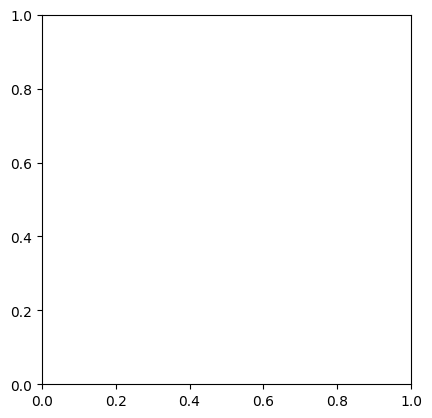

In [12]:
airport = "kbos"
base_dir = '../../datasets/amelia'
traj_version = 'a10v08'

traj_dir = os.path.join(base_dir, f'traj_data_{traj_version}/proc_trajectories', f'{airport}')

assets = load_assets(base_dir, airport)

trajdirs = [os.path.join(traj_dir, f) for f in os.listdir(traj_dir)]

for trajdir in trajdirs:
    scenarios_list = glob.glob(f"{trajdir}/*.pkl", recursive=True)
    for i, scenario in enumerate(scenarios_list):
        if i > 100:
            break

        with open(scenario, 'rb') as f:
            scene = pickle.load(f)

        subdir = os.path.join(out_dir, airport, trajdir.split('/')[-1])

        scenario_id = scene['scenario_id']

        os.makedirs(subdir, exist_ok=True)
        filetag = os.path.join(subdir, f"{scenario_id}")
        if not os.path.exists(filetag):
            plot_scene(scene, assets, filetag)